In [1]:
import os, random
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, auc
)

from datalaoader.csv_sequence_dataset import CSVSequenceDataset
from models.LSTM.BiLSTM_LSE           import LSE_Bidirectional_LSTM
from models.LSTM_ENCODER.Encoder_LSE  import LSE_Encoder

import matplotlib.pyplot as plt

def set_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seeds(42)  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
BASE_DIR   = Path('/home/gerardo')
BATCH_SIZE = 4
DROP_COLS  = ['frame']

CKPT = BASE_DIR / 'LSE_HEALTH/LSE_TFG/models/LSTM/BiLSTM-PADDED-NORMALICED-WEIGTHED-FOCAL-LOSS-GAMMA-3-79.pth'

CSV_TRAIN = BASE_DIR / 'LSE_HEALTH/LSE_TFG/train_test_val_split/train_weigthed_samples.csv'
CVS_VAL   = BASE_DIR / 'LSE_HEALTH/LSE_TFG/train_test_val_split/val_weigthed_samples.csv'
CSV_TEST  = BASE_DIR / 'LSE_HEALTH/LSE_TFG/train_test_val_split/test_weigthed_samples.csv'
NOVELTY_DIR = BASE_DIR / 'NoveltyDetectionProcessed'

FEATURES_DIR = BASE_DIR / 'FEATURES_POSE_DATASET'

In [3]:
# CARGA DE DATOS
def load_paths(csv_file):
    return pd.read_csv(csv_file).iloc[:, 0].dropna().tolist()

def group_by_video(paths):
    groups = defaultdict(list)
    for p in paths:
        key = "_".join(Path(p).stem.split("_")[:-1])
        groups[key].append(p)
    return list(groups.values())

def stratified_split(groups, ratio=0.1):
    random.shuffle(groups)
    n_train = int(len(groups) * ratio)
    return groups[:n_train], groups[n_train:]

def collate_fn(batch):
    seqs, labels, lengths = zip(*batch)
    seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=0)
    labels  = torch.tensor(labels)
    lengths = torch.tensor(lengths)
    lengths, idx = lengths.sort(descending=True)
    return seqs_padded[idx], labels[idx], lengths

def build_loader(root_dir, paths, shuffle=False):
    ds = CSVSequenceDataset(
        root_dir=root_dir, file_list=paths,
        drop_columns=DROP_COLS
    )
    loader = DataLoader(ds, batch_size=BATCH_SIZE,
                        shuffle=shuffle, collate_fn=collate_fn)
    return loader, ds


In [4]:
train_paths = load_paths(CSV_TRAIN)
test_paths  = load_paths(CSV_TEST)
val_paths    = load_paths(CVS_VAL)

ood_paths = [
    f"{c}/{f}" for c in os.listdir(NOVELTY_DIR)
    if (NOVELTY_DIR / c).is_dir()
    for f in os.listdir(NOVELTY_DIR / c) if f.endswith('.csv')
]

In [5]:
train_loader, train_ds = build_loader(FEATURES_DIR, train_paths, shuffle=True)
val_loader,   _        = build_loader(FEATURES_DIR, val_paths)
test_loader,  _        = build_loader(FEATURES_DIR, test_paths)
ood_loader,   _        = build_loader(NOVELTY_DIR,  ood_paths)

In [6]:
sample_seq, _, _ = train_ds[0]
in_size  = sample_seq.shape[1]
hid_size = in_size // 3
n_layers = 2

full_model = LSE_Bidirectional_LSTM(
    in_size, hid_size, n_layers,
    num_classes=len(train_ds.class_to_idx),
    dropout=0.5, bidirectional=True
).to(device)
full_model.load_state_dict(torch.load(CKPT, map_location=device))
full_model.eval()

encoder = LSE_Encoder(in_size, hid_size, n_layers).to(device)
encoder.load_state_dict({k: v for k, v in full_model.state_dict().items()
                         if 'fc' not in k})
encoder.eval()


LSE_Encoder(
  (lstm): LSTM(37, 12, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [7]:
@torch.no_grad()
def extract_embeddings(loader):
    E, L = [], []
    for x, y, lengths in loader:
        mask = lengths > 0
        if not mask.any(): continue
        x, lengths = x[mask].to(device), lengths[mask].to(device)
        y = y[mask]
        E.append(encoder(x, lengths).cpu().numpy())
        L.append(y.numpy())
    return np.vstack(E), np.concatenate(L)

emb_train, lbl_train = extract_embeddings(train_loader)
emb_val,   lbl_val   = extract_embeddings(val_loader)
emb_test,  lbl_test  = extract_embeddings(test_loader)
emb_ood,   _         = extract_embeddings(ood_loader)

# Prototipos de clase
protos = []
for c in range(len(train_ds.class_to_idx)):
    protos.append(emb_train[lbl_train == c].mean(0))
protos = np.stack(protos)

def cosine(u, v):
    return (u @ v)/(np.linalg.norm(u)*np.linalg.norm(v) + 1e-12)

def sim_feats(E):
    return np.stack([[cosine(e, p) for p in protos] for e in E])

from sklearn.preprocessing import normalize

# 1) Normaliza embeddings y prototipos
E_train_n = normalize(emb_train, axis=1)
protos_n   = normalize(protos, axis=1)

# 2) Calcula similitudes de golpe
sim_feats = lambda E: E @ protos_n.T

X_train = sim_feats(normalize(emb_train, axis=1))
X_val   = sim_feats(normalize(emb_val,   axis=1))
X_test  = sim_feats(normalize(emb_test,  axis=1))
X_ood   = sim_feats(normalize(emb_ood,   axis=1))

X_train = sim_feats(emb_train)
X_val   = sim_feats(emb_val)
X_test  = sim_feats(emb_test)
X_ood   = sim_feats(emb_ood)

# Estandarizador solo con Train-ID
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_val   = scaler.transform(X_val)
Xs_test  = scaler.transform(X_test)
Xs_ood   = scaler.transform(X_ood)

In [8]:
# ONE-CLASS SVM  (búsqueda ligera de ν y γ)
nus = [0.01, 0.05, 0.1, 0.2]
gammas = [1e-3, 1e-2, 1e-1, 1]
kernel = 'rbf'

best_auc = -np.inf
best_kernel = None
for nu in nus:
    for g in gammas:
        
        svm = OneClassSVM(nu=nu, kernel=kernel,
                        gamma=g / Xs_train.shape[1])
        svm.fit(Xs_train)

        X_mix = np.vstack([Xs_val, Xs_ood[:len(Xs_ood)//3]])
        y_mix = np.concatenate([np.ones(len(Xs_val)),
                                np.zeros(len(Xs_ood)//3)])
        auc_val = roc_auc_score(y_mix, svm.decision_function(X_mix))
        if auc_val > best_auc:
            best_auc, best_svm, best_cfg, best_kernel = auc_val, svm, (nu, g), kernel

print(f"Mejor OC-SVM: ν={best_cfg[0]}, γ={best_cfg[1]}, kernel={best_kernel}, AUC={best_auc:.4f}")

Mejor OC-SVM: ν=0.01, γ=0.001, kernel=rbf, AUC=0.6155


In [9]:
#MÉTRICAS Y CURVA ROC

def fpr_at_tpr(y, s, target_tpr=0.95):
    fpr, tpr, _ = roc_curve(y, s)
    idx = np.argmin(np.abs(tpr - target_tpr))
    return fpr[idx]

def aupr(y, s):
    pr, rc, _ = precision_recall_curve(y, s, pos_label=1)
    return auc(rc, pr)

y_true_novel = np.concatenate([
    np.zeros(len(Xs_test), dtype=int),
    np.ones(len(Xs_ood),  dtype=int)
])

raw = best_svm.decision_function(np.vstack([Xs_test, Xs_ood]))
scores = -raw

auroc_novel   = roc_auc_score(y_true_novel, scores)
fpr95_novel   = fpr_at_tpr(y_true_novel, scores, 0.95)
aupr_novel    = aupr(y_true_novel, scores)

res = pd.DataFrame({
    'Método':       ['OC-SVM'],
    'AUROC':        [auroc_novel],
    'FPR@95%TPR':   [fpr95_novel],
    'AUPR': [aupr_novel]
})

num_cols = res.select_dtypes('number').columns

display(res.style.format('{:.3f}', subset=num_cols))


,Método,AUROC,FPR@95%TPR,AUPR
0,OC-SVM,0.620,0.816,0.359


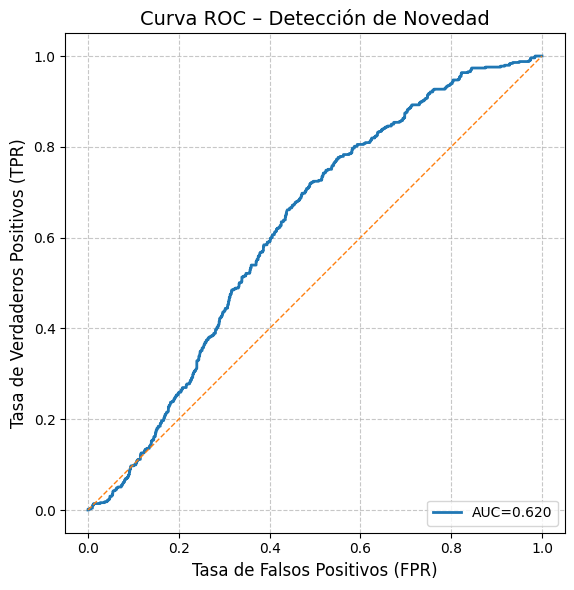

In [10]:
#PLOT ROC
fpr, tpr, _ = roc_curve(y_true_novel, scores)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC={auroc_novel:.3f}")
plt.plot([0,1],[0,1], '--', linewidth=1)
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Curva ROC – Detección de Novedad', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.axis('square')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()